## Training data-efficient image transformers & distillation through attention

Vision Transformers (ViT) are data hungry, to work well they were trained on a private dataset with 300 Images (JFT-300M) then finetuned for a different downstream task.

Data Efficient Image Transformers solves this problem by using **Knowledge Distillation** from another architecture (teacher) to a Transformer based Architecture - ViT-B (student) while using only one dataset (Imagenet)

From the paper; page 2:

In summary, our work makes the following contributions:
* We show that our neural networks that contains no convolutional layer
can achieve competitive results against the state of the art on ImageNet
with no external data. They are learned on a single node with 4 GPUs in
three days. Our two new models DeiT-S and DeiT-Ti have fewer parameters
and can be seen as the counterpart of ResNet-50 and ResNet-18.
* We introduce a new distillation procedure based on a distillation token,
which plays the same role as the class token, except that it aims at reproducing
the label estimated by the teacher. Both tokens interact in the
transformer through attention. This transformer-specific strategy outperforms
vanilla distillation by a significant margin.
* Interestingly, with our distillation, image transformers learn more from a
convnet than from another transformer with comparable performance.
* Our models pre-learned on Imagenet are competitive when transferred to
different downstream tasks such as fine-grained classification, on several
popular public benchmarks: CIFAR-10, CIFAR-100, Oxford-102 flowers,
Stanford Cars and iNaturalist-18/19.

### Knowledge Distillation

Knowledge Distillation (KD), introduced by Hinton et al. [24], refers to the
training paradigm in which a student model leverages “soft” labels coming
from a strong teacher network. This is the output vector of the teacher’s softmax
function rather than just the maximum of scores, wich gives a “hard” label.
Such a training improves the performance of the student model

In [98]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on {device}")

running on cuda


In [99]:
train_data_path = Path(r"C:\Users\bamilosin\Documents\dataset\vision\food vision data\pizza_steak_sushi-20%\train")
test_data_path = Path(r"C:\Users\bamilosin\Documents\dataset\vision\food vision data\pizza_steak_sushi-20%\test")

transforms = T.Compose([
    T.ToImage(),
    T.Resize((224,224)),
    T.ToDtype(torch.float, scale=True)
])

train_dataset = ImageFolder(train_data_path, transform=transforms)
test_dataset = ImageFolder(test_data_path, transform=transforms)

BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [100]:
images, labels = next(iter(train_dataloader))
idx_to_class = {idx: label for label, idx in train_dataset.class_to_idx.items()}

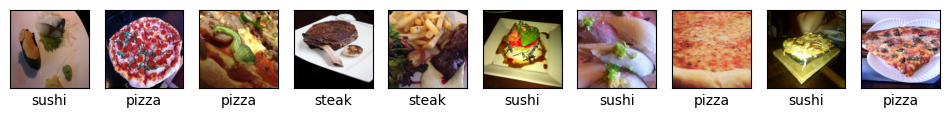

In [101]:
# plot random samples
samples = random.sample(k=10, population=range(0, len(images)))
fig, axs = plt.subplots(nrows=1, ncols=len(samples), figsize=(12,10))
for i, sample in enumerate(samples):
    axs[i].imshow(images[sample].permute(1,2,0))
    axs[i].set(xticks=[], yticks=[])
    axs[i].set_xlabel(f"{idx_to_class[labels[sample].item()]}")


### visualize patches

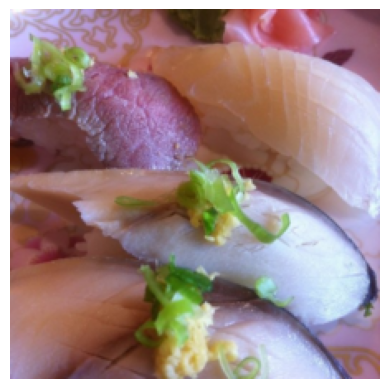

In [102]:
image = images[0].permute(1,2,0)
plt.imshow(image)
plt.axis('off')
plt.show()

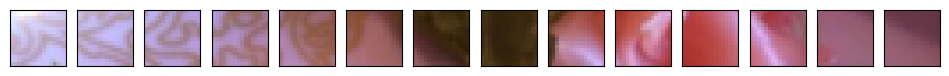

In [103]:
image_height = 224 # height
image_width = 224 # width
color_channels = 3 # color channels
patch_size = 16 # patch size


fig, axs = plt.subplots(nrows=1, ncols=image_height//patch_size, figsize=(12,10))
for i,patch in enumerate(range(0, image_height, patch_size)):
    axs[i].imshow(image[:patch_size, patch:patch+patch_size, :])
    axs[i].set(xticks=[], yticks=[])
plt.show()

Number of patches: 196


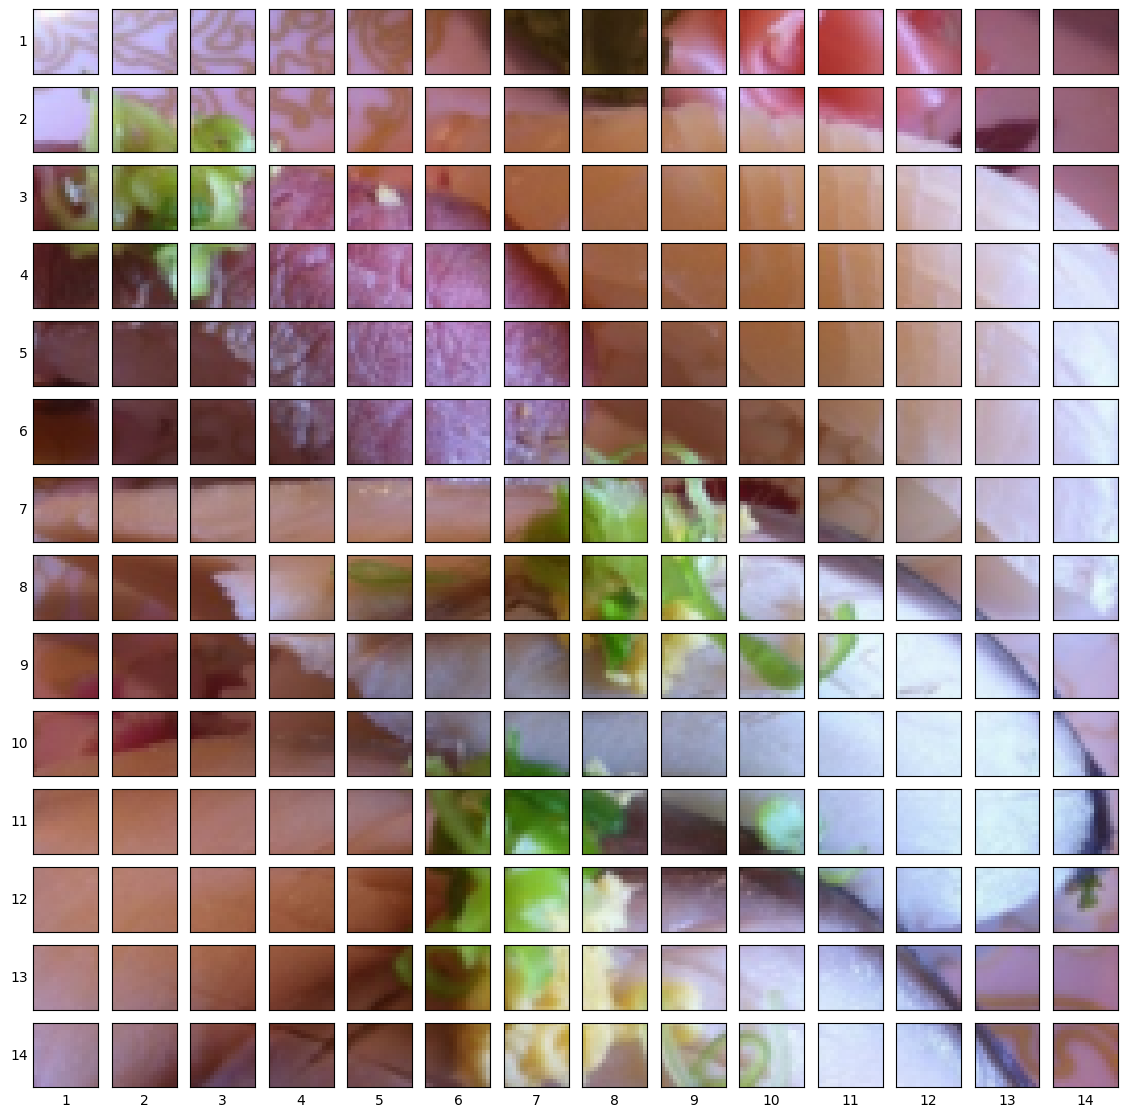

In [104]:
number_of_patches = (image_height * image_width) // patch_size**2
assert image_height % patch_size == 0, f"({image_height},{image_width} is not divisible by {patch_size})"
print(f"Number of patches: {number_of_patches}")

patch_per_row = image_height // patch_size

fig, axs = plt.subplots(nrows=patch_per_row, ncols=patch_per_row, figsize=(patch_per_row, patch_per_row))

for i, patch_x in enumerate(range(0, image_height, patch_size)):
    for j, patch_y in enumerate(range(0, image_width, patch_size)):
        axs[i,j].imshow(image[patch_x:patch_size+patch_x, patch_y:patch_y+patch_size])
        axs[i,j].set(xticks=[], yticks=[])
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].label_outer()
plt.show()

In [105]:
N = int((image_height * image_width) / patch_size**2)
embedding_dim = patch_size**2 * color_channels

print(f"input image shape: {(image_height, image_width, color_channels)}")
print(f"output embedding shape: {(1, N, embedding_dim)}")

input image shape: (224, 224, 3)
output embedding shape: (1, 196, 768)


In [106]:
image = images[0]
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=768,
                       kernel_size=16,
                       stride=16)
image_through_conv_layer = conv_layer(image.unsqueeze(0))

# flatten conv layer output to make 
flat = nn.Flatten(start_dim=-2, end_dim=-1)
flattened_image= flat(image_through_conv_layer)

# reshape image to match the expected output
patch_embeddings = flattened_image.permute(0,2,1)


print(f"input image shape: {(image_height, image_width, color_channels)}")
print(f"image through conv layer output: {image_through_conv_layer.shape}")
print(f"image through conv layer flattened: {flattened_image.shape}")
print(f"patch embedding: {patch_embeddings.shape}") # expected output


input image shape: (224, 224, 3)
image through conv layer output: torch.Size([1, 768, 14, 14])
image through conv layer flattened: torch.Size([1, 768, 196])
patch embedding: torch.Size([1, 196, 768])


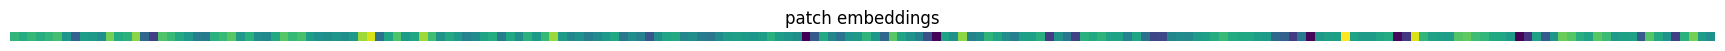

In [107]:
# visualize flattened image
fig = plt.figure(figsize=(22, 22))
plt.imshow(patch_embeddings[:, :, 0].detach().cpu())
plt.title(f"patch embeddings")
plt.axis('off')
plt.show()


In [108]:
# shape of patch embeddings
print(f"patch_embeddings: {patch_embeddings.shape}")

# prepend learnable class tokens
class_tokens = nn.Parameter(torch.ones(1, 1, embedding_dim), 
                            requires_grad=True)
patch_embeddings_with_class_tokens = torch.cat([class_tokens, patch_embeddings], dim=1)
print(f"class tokens + patch embeddings: {patch_embeddings_with_class_tokens.shape} ")


# create distillation tokens
distillation_tokens = nn.Parameter(torch.ones(1, 1, embedding_dim),
                                   requires_grad=True)
# append distillation tokens to embeddings
class_patch_embeddings_and_distillation_tokens = torch.cat([patch_embeddings_with_class_tokens, distillation_tokens], dim=1)
print(f"distillation token + class tokens + patch embeddings: {class_patch_embeddings_and_distillation_tokens.shape} ")


# add position embeddings to class + patch embeddings + distillation with class and distillation tokens
position_embeddings = nn.Parameter(torch.ones(1, number_of_patches+2, embedding_dim, requires_grad=True))
pos_dis_class_token_patch_embeddings = class_patch_embeddings_and_distillation_tokens + position_embeddings
print(f"position embeddings + class tokens + distillation tokens + patch embeddings: {pos_dis_class_token_patch_embeddings.shape} ")


patch_embeddings: torch.Size([1, 196, 768])
class tokens + patch embeddings: torch.Size([1, 197, 768]) 
distillation token + class tokens + patch embeddings: torch.Size([1, 198, 768]) 
position embeddings + class tokens + distillation tokens + patch embeddings: torch.Size([1, 198, 768]) 


### Patch Embeddings

In [109]:
class PatchEmbeddings(nn.Module):
    def __init__(self,
                img_size:int=224,
                patch_size:int=16,
                embed_dim:int=768):
        super(PatchEmbeddings, self).__init__()

        # number of patches
        num_patches = int((img_size * img_size) / patch_size**2)
        assert ((img_size * img_size)  % patch_size**2) == 0, f"image size: {img_size} is not divisible by patch_size: {patch_size}"

        # conv layer
        self.conv_layer = nn.Conv2d(in_channels=3,
                                    out_channels=embed_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size
        )
        
        self.embed_dim = embed_dim

        # flat embeddings
        self.flat_layer = nn.Flatten(start_dim=-2, end_dim=-1)

        # class tokens
        self.class_tokens = nn.Parameter(torch.randn(1, 1, embed_dim),
                                         requires_grad=True)

        # distillation tokens
        self.distillation_tokens = nn.Parameter(torch.randn(1, 1, embed_dim),
                                                requires_grad=True)

        # position embeddings
        self.pos_embeddings = nn.Parameter(torch.randn(1,num_patches+2, embed_dim),
                                           requires_grad=True)

    def forward(self, x):
        # batch size
        batch_size = x.shape[0]
        # expand class tokens to match batch size
        class_tokens = self.class_tokens.expand(batch_size, -1, -1)
        # expand distillation tokens to match batch size
        distillation_tokens = self.distillation_tokens.expand(batch_size, -1, -1)


        # get patch embeddings
        patch_embeddings = self.conv_layer(x) # output: (batch_size, 196, 768)
        # flatten embeddings
        flattened_patch_embeddings = self.flat_layer(patch_embeddings).permute(0,2,1)

        # prepend class tokens to patch embeddings
        class_tokens_patch_embeddings = torch.cat([class_tokens, flattened_patch_embeddings], dim=1)

        # append distillation tokens to embeddings
        distillation_and_class_tokens_patch_embeddings = torch.cat([class_tokens_patch_embeddings, distillation_tokens], dim=1)

        # add position embeddings
        pos_distillation_and_class_tokens_patch_embeddings = distillation_and_class_tokens_patch_embeddings + self.pos_embeddings

        return pos_distillation_and_class_tokens_patch_embeddings

In [110]:
image = images[0].unsqueeze(dim=0)
image.shape

torch.Size([1, 3, 224, 224])

In [111]:
patcher = PatchEmbeddings()
embeds = patcher(image)

print(f"input image shape: {image.shape}")
print(f"embedding output shape: {embeds.shape}")

input image shape: torch.Size([1, 3, 224, 224])
embedding output shape: torch.Size([1, 198, 768])


### Multihead Self-Attention

In [112]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embed_dim:int=768, num_heads:int=12, attn_dropout:int=0):
        super(MultiheadSelfAttention, self).__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)

        self.msa = nn.MultiheadAttention(embed_dim=embed_dim,
                                         num_heads=num_heads,
                                         batch_first=True,
                                         dropout=attn_dropout)
        

    def forward(self, x):
        x_norm = self.layer_norm(x)
        attn_ouput, _ = self.msa(query=x,
                                 key=x,
                                 value=x,
                                 need_weights=False)
        return attn_ouput + x

In [113]:
msa = MultiheadSelfAttention()
msa_output = msa(embeds)

print(f"msa input: {pos_dis_class_token_patch_embeddings.shape}")
print(f"msa output: {msa_output.shape}")

msa input: torch.Size([1, 198, 768])
msa output: torch.Size([1, 198, 768])


### MLP Layer

In [114]:
class MLPLayer(nn.Module):
    def __init__(self, embed_dim:int=768, mlp_dim:int=3072, dropout:float=0.1):
        super(MLPLayer, self).__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)

        self.mlp_layer = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=mlp_dim),
            nn.Dropout(p=dropout),
            nn.GELU(),
            nn.Linear(in_features=mlp_dim, out_features=embed_dim),
            nn.Dropout(p=dropout),
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        return self.mlp_layer(x) + x

In [115]:
mlp = MLPLayer()
mlp_out = mlp(msa_output)

print(f"mlp input: {msa_output.shape}")
print(f"mlp output: {mlp_out.shape}")

mlp input: torch.Size([1, 198, 768])
mlp output: torch.Size([1, 198, 768])


### Transformer Encoder

In [116]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 embed_dim:int=768,
                 mlp_dim:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 mlp_dropout:float=0.1):
        super(TransformerEncoder, self).__init__()

        self.msa = MultiheadSelfAttention(embed_dim=embed_dim,
                                          num_heads=num_heads,
                                          attn_dropout=attn_dropout)
        self.mlp = MLPLayer(embed_dim=embed_dim,
                            mlp_dim=mlp_dim,
                            dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa(x)
        return self.mlp(x)

In [117]:
transformer_encoder = TransformerEncoder()
transformer_encoder = transformer_encoder(pos_dis_class_token_patch_embeddings)

print(f"Transformer Encoder Output: {transformer_encoder.shape}")

Transformer Encoder Output: torch.Size([1, 198, 768])


### DeiT Model

In [118]:
class DeiT(nn.Module):
    def __init__(self, 
                 img_size:int=224,
                 patch_size:int=16,
                 embed_dim:int=768,
                 mlp_dim:int=3072,
                 num_heads:int=12,
                 num_layers:int=12,
                 embedding_dropout:float=0.1,
                 attn_dropout:int=0,
                 mlp_dropout:float=0.1,
                 num_classes:int=3):
        super(DeiT, self).__init__()

        self.patchifier = PatchEmbeddings(img_size=img_size,
                                          patch_size=patch_size,
                                          embed_dim=embed_dim)
        
        self.patch_embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.transformer_encoder_layer = nn.Sequential(
            *[TransformerEncoder(embed_dim=embed_dim,
                                 mlp_dim=mlp_dim,
                                 num_heads=num_heads,
                                 attn_dropout=attn_dropout,
                                 mlp_dropout=mlp_dropout) for _ in range(num_layers)]
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
        
        # self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        
    def forward(self, x):
        # get patch embeddings
        patch_embeddings = self.patchifier(x)

        # add dropout after adding positional embeddings to patch embeddings
        dropout_patch_embeddings = self.patch_embedding_dropout(patch_embeddings)

        # pass patch embeddings through transformer encoder layer
        encoder_output = self.transformer_encoder_layer(dropout_patch_embeddings)

        # pass class token through classifier
        class_token_logits = self.classifier(encoder_output[:, 0, :])

        # pass distillation token through classifier
        distillation_token_logits = self.classifier(encoder_output[:, -1, :])

        return class_token_logits, distillation_token_logits

In [119]:
deit_model = DeiT().to(device)
summary(deit_model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "trainable"], row_settings=["var_names", "ascii_only"])

Layer (type (var_name))                       Input Shape               Output Shape              Trainable
DeiT (DeiT)                                   [1, 3, 224, 224]          [1, 3]                    True
+ PatchEmbeddings (patchifier)                [1, 3, 224, 224]          [1, 198, 768]             True
|    + Conv2d (conv_layer)                    [1, 3, 224, 224]          [1, 768, 14, 14]          True
|    + Flatten (flat_layer)                   [1, 768, 14, 14]          [1, 768, 196]             --
+ Dropout (patch_embedding_dropout)           [1, 198, 768]             [1, 198, 768]             --
+ Sequential (transformer_encoder_layer)      [1, 198, 768]             [1, 198, 768]             True
|    + TransformerEncoder (0)                 [1, 198, 768]             [1, 198, 768]             True
|    |    + MultiheadSelfAttention (msa)      [1, 198, 768]             [1, 198, 768]             True
|    |    + MLPLayer (mlp)                    [1, 198, 768]             

In [120]:
with torch.no_grad():
    student_logits, teacher_logits = deit_model(image.to(device))
print(f"student logits: {student_logits}")
print(f"teacher logits: {teacher_logits}")


student logits: tensor([[0.2293, 0.8019, 0.6886]], device='cuda:0')
teacher logits: tensor([[0.1403, 0.5104, 0.7266]], device='cuda:0')


## Knowledge Distillation Process


from: https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html#knowledge-distillation-run

* The method works by incorporating an additional loss into the traditional cross entropy loss, which is based on the softmax output of the teacher network.
* The assumption is that the output activations of a properly trained teacher network carry additional information that can be leveraged by a student network during training.
* The original work suggests that utilizing ratios of smaller probabilities in the soft targets can help achieve the underlying objective of deep neural networks, which is to create a similarity structure over the data where similar objects are mapped closer together
* For example, in CIFAR-10, a truck could be mistaken for an automobile or airplane, if its wheels are present, but it is less likely to be mistaken for a dog.
* Therefore, it makes sense to assume that valuable information resides not only in the top prediction of a properly trained model but in the entire output distribution.
* However, cross entropy alone does not sufficiently exploit this information as the activations for non-predicted classes tend to be so small that propagated gradients do not meaningfully change the weights to construct this desirable vector space.

Extra parameters to note:
* T: Temperature controls the smoothness of the output distributions. Larger T leads to smoother distributions, thus smaller probabilities get a larger boost.
* soft_target_loss_weight: A weight assigned to the extra objective we’re about to include.
* ce_loss_weight: A weight assigned to cross-entropy. Tuning these weights pushes the network towards optimizing for either objective.

![alt text](img/distillation_output_loss.png)

### The Teacher Model

RegNetY-4GF

In [32]:
weights = torchvision.models.RegNet_Y_8GF_Weights.DEFAULT
reg_net = torchvision.models.regnet_y_8gf(weights=weights).to(device)
summary(reg_net, (1,3,224,224), col_names=["input_size", "output_size", "trainable"], row_settings=["var_names", "ascii_only"])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
RegNet (RegNet)                                              [1, 3, 224, 224]          [1, 1000]                 True
+ SimpleStemIN (stem)                                        [1, 3, 224, 224]          [1, 32, 112, 112]         True
|    + Conv2d (0)                                            [1, 3, 224, 224]          [1, 32, 112, 112]         True
|    + BatchNorm2d (1)                                       [1, 32, 112, 112]         [1, 32, 112, 112]         True
|    + ReLU (2)                                              [1, 32, 112, 112]         [1, 32, 112, 112]         --
+ Sequential (trunk_output)                                  [1, 32, 112, 112]         [1, 2016, 7, 7]           True
|    + AnyStage (block1)                                     [1, 32, 112, 112]         [1, 224, 56, 56]          True
|    |    + ResBottleneckBlock (block1-0)            

In [33]:
# freeze all layers for regnety model
for param in reg_net.parameters():
    param.requires_grad = False

## edit fc head(classifier head) of RegnetY model
reg_net.fc = nn.Linear(in_features=2016,
                       out_features=3,
                       bias=True).requires_grad_(True)

summary(reg_net, (1,3,224,224), col_names=["input_size", "output_size", "trainable"], row_settings=["var_names", "ascii_only"])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
RegNet (RegNet)                                              [1, 3, 224, 224]          [1, 3]                    Partial
+ SimpleStemIN (stem)                                        [1, 3, 224, 224]          [1, 32, 112, 112]         False
|    + Conv2d (0)                                            [1, 3, 224, 224]          [1, 32, 112, 112]         False
|    + BatchNorm2d (1)                                       [1, 32, 112, 112]         [1, 32, 112, 112]         False
|    + ReLU (2)                                              [1, 32, 112, 112]         [1, 32, 112, 112]         --
+ Sequential (trunk_output)                                  [1, 32, 112, 112]         [1, 2016, 7, 7]           False
|    + AnyStage (block1)                                     [1, 32, 112, 112]         [1, 224, 56, 56]          False
|    |    + ResBottleneckBlock (block1-0)    

In [34]:
def accuracy(logits, y_truth):
    acc = torch.eq(torch.argmax(logits, -1), y_truth).sum()
    return (acc / len(y_truth)) * 100

#### Finetune Reg-NetY 8GF model on Food Vision Mini dataset

In [80]:
def train(model,
          train_dataloader,
          optimizer,
          loss_fn,
          epochs:int,
          device):
    
    loss_fn = loss_fn.to(device)

    history = {
        "train_loss": [],
        "train_acc": []
    }

    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0.0, 0.0
        for image, label in train_dataloader:
            image, label = image.to(device), label.to(device)

            logit = model(image)
            loss = loss_fn(logit, label)
            acc = accuracy(logit, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc.item()

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        print(f"{epoch+1}/{epochs} | train_loss: {train_loss:.5f} | train_acc: {train_acc:.2f}%")

    return history




def test(model,
         test_dataloader,
         loss_fn,
         epochs:int,
         device):
    
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device) 

        with torch.no_grad():
            logits = model(images)

            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            test_loss += loss.item()
            test_acc += acc.item()

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test Loss: {test_loss:.5f}")       



In [ ]:
optimizer = torch.optim.Adam(reg_net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

history = train(reg_net, train_dataloader, optimizer, loss_fn, 15, device)

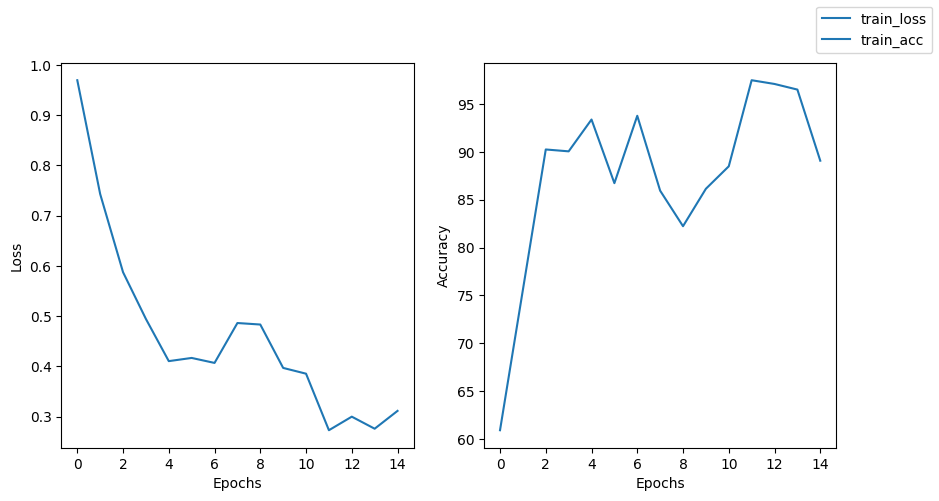

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].plot(history["train_loss"], label="train_loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(history["train_acc"], label="train_acc")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

fig.legend()
plt.show()


In [84]:
# test regnet-y model
test_history = test(model=reg_net, test_dataloader=test_dataloader, loss_fn=loss_fn, epochs=10, device=device)

Test Accuracy: 91.86%
Test Loss: 0.24335


In [85]:
image = images[13]
image.shape

torch.Size([3, 224, 224])

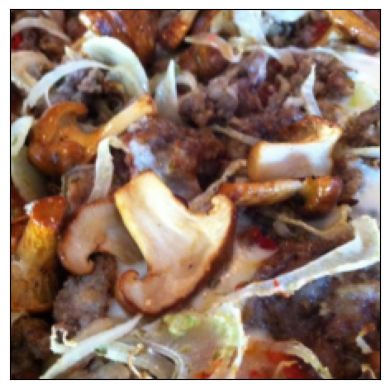

In [86]:
plt.imshow(image.permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()

In [87]:
pred = torch.argmax(reg_net(image.unsqueeze(0).to(device)), -1).item()
idx_to_class[pred]

'pizza'

#### using a  pretrained vit-B model doesnt make sense because it has already been trained on JFT 300M dataset, so it wouldnt make sense for testing

In [45]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_model = torchvision.models.vit_b_16(weights=vit_weights)

TODO:
* finetune regnety-4gf food_vision mini dataset
* write code for training with knowledge distillation
* compare results with:
    * regnety-4gf on food vision mini
    * DeiT-B on food vision mini
    * ViT-B on food vision mini

### train knowledge distillation model



In [ ]:
def train_distillation():
    pass

In [93]:
def train_knowledge_distillation(teacher,
                                 student,
                                 train_dataloader,
                                 epochs,
                                 learning_rate,
                                 temp,
                                 soft_target_loss_weight,
                                 ce_loss_weight,
                                 device):
    
    history = {
        "c_train_loss": [],
        "d_train_loss": []
    }

    ce_loss = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        c_running_loss, running_loss = 0.0, 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # prevent gradients from accumulating

            # forward pass with teacher model - just inference
            with torch.no_grad():
                teacher_logits = teacher(images)

            # forward pass with student model
            class_logits, distill_logits = student(images)

            # soften the student logits
            soft_targets = F.softmax(teacher_logits / temp, dim=-1)
            #  distill logits as student logits
            soft_prob = F.log_softmax(distill_logits / temp, -1)

            # calculate the soft target loss, scaled by T**2 as suggested by paper
            soft_target_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[-1] * (temp**2)

            # true label loss
            label_loss = ce_loss(soft_target_loss, labels)
            class_loss = ce_loss(class_logits, labels) 

            # weighted sum of two losses
            loss = soft_target_loss_weight * soft_target_loss + ce_loss_weight * label_loss
        
            loss.backward() # back prop for distillation loss
            class_loss.backward() # backprop for class token loss
            optimizer.step()

            running_loss += loss.item()
            c_running_loss += class_loss.item()
        
        running_loss /= len(train_dataloader)
        c_running_loss /= len(train_dataloader)

        history["d_train_loss"].append(running_loss)
        history['c_train_loss'].append(c_running_loss)
        
        print(f"{epoch+1}/{epochs} | distillation loss: {running_loss:.4f} | class token loss: {c_running_loss:.4f}")

    return history



In [94]:
train_knowledge_distillation(teacher=reg_net,
                             student=deit_model,
                             train_dataloader=train_dataloader,
                             epochs=1,
                             learning_rate=1e-3,
                             temp=2,
                             soft_target_loss_weight=0.25,
                             ce_loss_weight=0.15,
                             device=device)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)